### Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

## Abertura e Tratamento do Arquivo
- Abri o arquivo .txt
- Extrair a quantidade de processadores do Servidor
- Tratar a entrada de dados

In [ ]:
# Nome do Arquivo atual
arq = "caso20000"

with open(f"Entrada de Arquivos/{arq}.txt") as arquivo:
    caso = arquivo.readlines()

cpu = int(str(caso[0])[7:])
tasks = list(map(lambda x: x[:-1], caso[1:]))

# --Visualização-- #
print(f"Numero de Processadores: {cpu}")
print(f"Lista de Taske: {tasks}")

- Tratar a saída de Task retirando as "->"
- Transformar a saída em tuplas (pai, filho)

In [ ]:
def separeting(string:str):
    word = string.split('->')
    pai = word[0].strip()
    filho = word[1].strip()
    return pai, filho

# --Visualização-- #
print(list(map(separeting, tasks)))

## Criar um algoritmo Modificado de Árvore de Busca

- Criar a classe Node
- Criar um algoritmo de Árvore convencional
    - O algoritmo deve caminhar pela árvore utilizando o número de CPU's disponiveis
    - Definir duas políticas de caminhamento na árvore ("MIN")-("MAX")
    - Criar uma função de caminhamento para utilizar as duas políticas 

### Classe Node

In [5]:
class Node():
    def __init__(self, valor, tempo):
        self.valor = valor
        self.tempo_restante = tempo
        self.tempo_restante_original = tempo
        self.filhos = []
        self.pai = None
        self.free = False

    def adicionar_filho(self, filho):
        filho.pai = self
        self.filhos.append(filho)
        

### Class ProcessTree
- Classe de Árvore de Busca adaptado

In [6]:
class ProcessTree():
    def __init__(self):
        self.root = None
        self.nodes = {}

    def get_or_create(self, nome):
        if nome not in self.nodes:
            ident, tempo = nome.split("_")
            tempo = int(tempo)
            self.nodes[nome] = Node(ident, tempo)
        return self.nodes[nome]
    
    def add_relation(self, pai_nome, filho_nome):
        pai = self.get_or_create(pai_nome)
        filho = self.get_or_create(filho_nome)
        pai.adicionar_filho(filho)

    def find_root(self):
        for node in self.nodes.values():
            if node.pai is None:
                self.root = node
                node.free = True
                return node
        return None

    def insert(self, valor, tempo):
        new = Node(valor, tempo)
        if self.root is None:
            new.free = True
            self.root = new
            return
        fila = [self.root]
        while fila:
            node = fila.pop(0)
            if not node.filhos or valor < node.filhos[-1].valor:
                node.adicionar_filho(new)
                break
            else:
                fila.extend(node.filhos)

    def reset(tree):
        for node in tree.nodes.values():
            node.tempo_restante = node.tempo_restante_original
            node.free = False
        tree.find_root()  # garante que a root fique free no início

    def pre_execution(self, politica="MIN"):
        prontos = []
        fila = [self.root]
        while fila:
            node = fila.pop(0)
            if node.free and node.tempo_restante > 0:
                prontos.append(node)
            fila.extend(node.filhos)
        
        if politica == "MIN":
            return sorted(prontos, key=lambda x: x.valor)
        elif politica == "MAX":
            return sorted(prontos, key=lambda x: x.valor, reverse=True)
        else:
            raise ValueError("Política deve ser 'MIN' ou 'MAX'")

    
    def execution(self, cpu, politica="MIN"):
        total_time = 0
        while True:
            prontos = self.pre_execution(politica)
            if not prontos:
                break

            ativos = prontos[:cpu]
            menor_tempo = min(node.tempo_restante for node in ativos)
            total_time += menor_tempo

            for node in ativos:
                node.tempo_restante -= menor_tempo
                if node.tempo_restante == 0:
                    for filho in node.filhos:
                        filho.free = True

        return total_time

## Prepara para Inserir na Árvore
- Atribuir as Tasks (pai, filho) à Árvore
- Setar a nova root

In [56]:
# Criar a ProcessTree e Setar a Politica de Caminhamento
p_tree = ProcessTree()
politica = ["MIN", "MAX"]
result = {}

# Adicionar os nodos a Árvore
for pai, filho in map(separeting, tasks):
    p_tree.add_relation(pai, filho)

# Procura a Root
p_tree.find_root()

# Faz o Caminhamento de Acordo com a Política e retorna o tempo
for pol in politica:
    inicio = time()
    p_tree.reset()
    total_time = p_tree.execution(cpu=cpu, politica=pol)
    fim = time()
    result[pol] = total_time
    result[f"Tempo_{pol}"] = fim-inicio

# --Visualização-- #
print(result)

{'MIN': 37720, 'Tempo_MIN': 152.09685158729553, 'MAX': 38896, 'Tempo_MAX': 153.106431722641}


## Criar um Arquivo .txt contendo os logs de cada caso.

- Abrir/Criar um arquivo .txt e armazenar os logs nele
- O arquivo deve conter:
    - Nome do Caso Estudado
    - N° de Processador
    - Política Utilizada
    - Tempo Simulado
    - Tempo Real de Execução

In [57]:
with open("Saida de Arquivos/log.txt", "a") as log:
    linha = (f"Arquivo:{f'{arq}.txt'} | CPU:{cpu} | MIN:{result["MIN"]} | MAX:{result["MAX"]} | Temp_MIN:{result["Tempo_MIN"]} | Temp_MAX:{result["Tempo_MAX"]}\n")
    log.write(linha)

## Gerar Relatórios sobre o Desempenho da ProcessTree

    - Fazer um Relatório de tempo em Relação às Políticas "MIN" e "MAX"
        - Criar um data frame a partir do "log.txt"
        - Criar uma coluna "Delta" (Diferença de MIN e MAX)
        - Gerar um Arquivo Tabelas_log.xlsx

In [66]:
# Abri o arquivo "log.txt" e transforma ele em um DataFrame
log_df = pd.read_csv("Saida de Arquivos/log.txt", sep='|', header=None, names=['Arquivo', 'CPU', 'MIN', 'MAX', 'Temp_MIN', 'Temp_MAX'])

# Trata as entradas do .txt para ter uma planilha limpa
log_df["Arquivo"] = log_df["Arquivo"].str.split(":").str[1].astype(str)
log_df["Arquivo"] = log_df["Arquivo"].str.replace('.txt', '', regex=False)
log_df["MIN"] = log_df["MIN"].str.split(":").str[1].astype(int)
log_df["MAX"] = log_df["MAX"].str.split(":").str[1].astype(int)
log_df["CPU"] = log_df["CPU"].str.split(":").str[1].astype(int)
log_df["Delta max|min"] = (log_df["MIN"] - log_df["MAX"]).abs() # Cria a Coluna Delta com a diferença entra MAX e MIN
log_df["Temp_MIN"] = log_df["Temp_MIN"].str.split(":").str[1].astype(float).abs()
log_df["Temp_MAX"] = log_df["Temp_MAX"].str.split(":").str[1].astype(float).abs()

# Cria um arquivo .xlsx a partir do DataFrame
with pd.ExcelWriter("Saida de Arquivos/Tabelas_log.xlsx") as writer:
    log_df.to_excel(writer, sheet_name="Resultados", index=False)

# --Visualização-- #
log_df

,Arquivo,CPU,MIN,MAX,Temp_MIN,Temp_MAX,Delta max|min
0,caso5,4,783,783,0.000045,0.000027,0
1,caso6,4,1157,1157,0.000100,0.000038,0
2,caso7,4,767,767,0.000082,0.000037,0
3,caso10,5,1568,1568,0.000072,0.000060,0
4,caso100,12,3315,3315,0.003328,0.003054,0
5,caso200,16,4657,4691,0.013566,0.012026,34
6,caso500,24,6932,7742,0.072259,0.065811,810
7,caso1000,33,9023,9332,0.284756,0.261035,309
8,caso2000,46,13489,15560,1.007219,0.938829,2071
9,caso5000,72,19501,20519,6.909020,6.697659,1018


## Construir Gráficos sobre o Desempenho da ProcessTree

- Gerar Gráficos para utilização no trabalho de Pesquisa
    - Gráfico individual de cada Caso (Gráfico de Barras)
    - Gráfico de linhas mostrando a diferença entre politicas
    - Gráfico de Todos os Testes (Gráfico de Barras)

### Gráfico Isolado
        - Gera um Gráfico Isolado de Colunas para melhor referencia de Otimização entre políticas
        - Adiciona uma linha Tracejada para melhorar a visualização da Diferença 

In [ ]:
for arq in log_df["Arquivo"].unique():
    df_caso = log_df[log_df["Arquivo"] == arq]
    
    plt.figure(figsize=(6,4))
    sns.barplot(data=df_caso.melt(id_vars=["Arquivo"], value_vars=["MIN","MAX"]),
                x="variable", y="value", palette=["#6baed6", "#fc9272"])
    
    # Pega o valor da altura da barra MAX
    max_val = df_caso["MAX"].values[0]
    
    # Adiciona linha tracejada do topo da barra até o eixo Y
    plt.hlines(y=max_val, xmin=-0.2, xmax=1.2, colors="gray", linestyles="--", linewidth=1)
    
    plt.title(f"Tempos do caso: {arq}")
    plt.ylabel("Tempo total")
    plt.xlabel("")
    plt.savefig(f"Saida de Arquivos/Graficos Isolados/caso_isolado_{arq}.png", dpi=300, bbox_inches="tight")
    plt.close()

### Gráfico Geral de Barras
     - Gera um Gráfico Geral de Colunas para melhor referencia de Otimização entre políticas

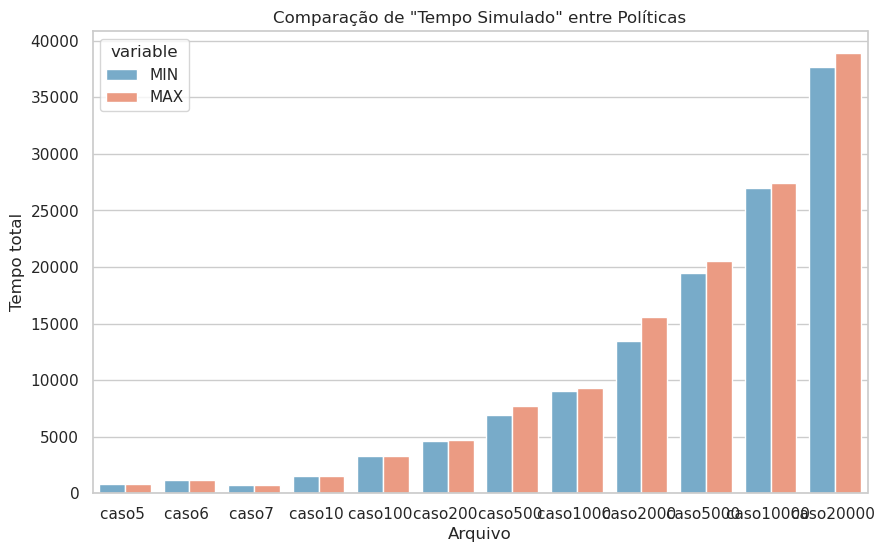

In [67]:
# Gráfico comparativo
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=log_df.melt(id_vars=["Arquivo"], value_vars=["MIN","MAX"]),
            x="Arquivo", y="value", hue="variable", palette=["#6baed6", "#fc9272"])
plt.ylabel("Tempo total")
plt.title('Comparação de "Tempo Simulado" entre Políticas')

# salvar como png
plt.savefig(f"Saida de Arquivos/grafico{arq}.png", dpi=300, bbox_inches="tight")

plt.show()

### Gráfico Geral de Linha
     - Gera um Gráfico Geral de Linhas para melhor referencia de Otimização entre políticas

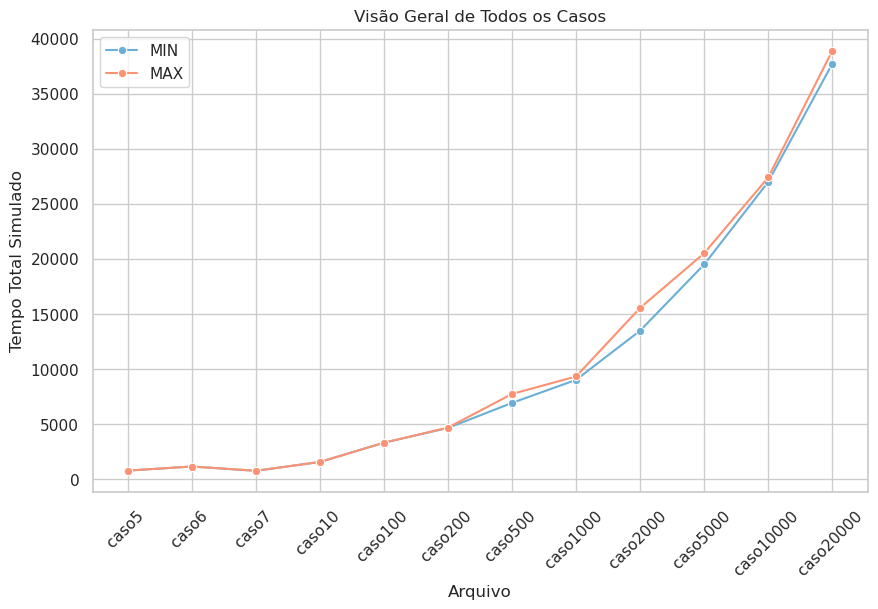

In [68]:
plt.figure(figsize=(10,6))
for var, cor in zip(["MIN","MAX"], ["#6baed6", "#fc9272"]):
    sns.lineplot(data=log_df.melt(id_vars=["Arquivo"], value_vars=[var]), 
                 x="Arquivo", y="value", label=var, color=cor, marker="o")
plt.title("Visão Geral de Todos os Casos")
plt.ylabel("Tempo Total Simulado")
plt.xlabel("Arquivo")
plt.xticks(rotation=45)
plt.legend()
plt.savefig("Saida de Arquivos/grafico_geral_de_linhas.png", dpi=300, bbox_inches="tight")
plt.show()